In [1]:
import scanpy as sc
import anndata as ad
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from matplotlib import rcParams

# verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.verbosity = 3               
sc.logging.print_version_and_date()

#making sure plots & clusters are reproducible
np.random.seed(42)

Running Scanpy 1.9.1, on 2022-12-11 11:59.


In [2]:
## paths
exvivo_dir = '/home/niklas/projects/niche_environments_FIBROSIS/HUMAN_exvivo/01_data/221123_PCLS_human_ASK_joint_celltype_marker_table_OVERALL.csv'
invivo_dir = '/home/niklas/projects/niche_environments_FIBROSIS/HUMAN_invivo/01_data/marker_table/220209_CPC_IPF_reference_ALL_markers_table_celltype_niklas_OVERALL.csv'
dge_dir = '/home/niklas/projects/niche_environments_FIBROSIS/PCLS_human/01_data/ASK_joint/DGE_treatment_vs_FC/'
results_dir = '/home/niklas/projects/niche_environments_FIBROSIS/HUMAN_invivo_exvivo_comparison/01_data/GSEA/'
fig_dir = '/home/niklas/projects/niche_environments_FIBROSIS/HUMAN_invivo_exvivo_comparison/02_figures/ASK_joint/aberrant_basaloid_treatment_effects/'

In [3]:
## plotting variables
sc.settings.figdir = fig_dir
sc.set_figure_params(vector_friendly = True)
plt.rcParams['figure.figsize'] = (8, 14)
plt.rcParams['pdf.fonttype'] = 42

In [4]:
## read aberrant basaloid invivo marker genes
invivo_marker = pd.read_csv(invivo_dir, index_col = 'gene')
invivo_marker = invivo_marker[invivo_marker['cell_type'] == 'Aberrant Basaloid']
invivo_marker = invivo_marker[['logfoldchange','pval_adj','pct_cell_type','pct_background']]

In [5]:
## read aberrant basaloid ex vivo marker genes
exvivo_marker = pd.read_csv(exvivo_dir, index_col = 'gene')
exvivo_marker = exvivo_marker[exvivo_marker['cell_type'] == 'Aberrant Basaloid']
exvivo_marker = exvivo_marker[['logfoldchange','pval_adj','pct_cell_type','pct_background']]

In [6]:
## read aberrant basaloid DGE genes after Nintedanib treatment
nintedanib = pd.read_csv(dge_dir + '221204_PCLS_human_ASK_joint_Aberrant_Basaloid_FC+Nintedanib_vs_FC_DGE_results.csv', index_col=0)
nintedanib = nintedanib[['log2fc','qval','pct.FCs','pct.FC+Nintedanibs']]

In [7]:
## read aberrant basaloid DGE genes after cmp4 treatment
cmp4 = pd.read_csv(dge_dir + '221204_PCLS_human_ASK_joint_Aberrant_Basaloid_FC+CMP4_vs_FC_DGE_results.csv', index_col=0)
cmp4 = cmp4[['log2fc','qval','pct.FCs','pct.FC+CMP4s']]

In [8]:
## overlap of invivo and exvivo marker genes
shared_markers = np.intersect1d(invivo_marker.index, exvivo_marker.index)
union_markers = np.union1d(invivo_marker.index, exvivo_marker.index)

In [9]:
# replace exorbitant high logFC values
cmp4['log2fc'] = [10 if logfc > 10 else logfc for logfc in cmp4['log2fc']]
cmp4['log2fc'] = [-10 if logfc < -10 else logfc for logfc in cmp4['log2fc']]
nintedanib['log2fc'] = [10 if logfc > 10 else logfc for logfc in nintedanib['log2fc']]
nintedanib['log2fc'] = [-10 if logfc < -10 else logfc for logfc in nintedanib['log2fc']]

In [10]:
## rename columns
invivo_marker.rename(columns = {'logfoldchange':str('invivo_log2FC'),
                               'pval_adj':str('invivo_pval_adj'),
                               'pct_cell_type':str('invivo_pct_cell_type'),
                               'pct_background':str('invivo_pct_background')}, inplace = True)
exvivo_marker.rename(columns = {'logfoldchange':str('exvivo_log2FC'),
                               'pval_adj':str('exvivo_pval_adj'),
                               'pct_cell_type':str('exvivo_pct_cell_type'),
                               'pct_background':str('exvivo_pct_background')}, inplace = True)
cmp4.rename(columns = {'log2fc':str('CMP4_log2FC'),
                       'qval':str('CMP4_pval_adj'),
                       'pct.FCs':str('CMP4_pct_FC'),
                       'pct.FC+CMP4s':str('CMP4_pct_FC_CMP4')}, inplace = True)
nintedanib.rename(columns = {'log2fc':str('Nintedanib_log2FC'),
                               'qval':str('Nintedanib_pval_adj'),
                               'pct.FCs':str('Nintedanib_pct_CC'),
                               'pct.FC+Nintedanibs':str('Nintedanib_pct_FC_Nintedanib')}, inplace = True)

In [11]:
## merge tables
master = pd.concat([invivo_marker, exvivo_marker, cmp4, nintedanib], axis=1, join='outer')

### Perform GSEA analysis

In [12]:
import gseapy as gp

In [13]:
# define genesets of interest
input_genesets = ['MSigDB_Hallmark_2020','GO_Biological_Process_2021','GO_Cellular_Component_2021','GO_Molecular_Function_2021','Reactome_2016','KEGG_2021_Human']

In [14]:
### download library or read a .gmt file
#go_mf = gp.get_library(name='GO_Biological_Process_2021', organism='Human')

In [15]:
for condition in ['Nintedanib','CMP4']:
    ## identify marker genes that were suppressed by treatment
    geneset = master[master.index.isin(shared_markers)]
    geneset = geneset[geneset[str(condition+'_log2FC')] < -0.5]
    geneset = geneset.index.tolist()
    
    ## GSEA on these genes
    if len(geneset) > 0:
        geneset_enr = gp.enrichr(gene_list=geneset,
                                   gene_sets=input_genesets,
                                   organism='Human',
                                   #description=str('Aberrant Basaloid markers: DOWN regulated by '+condition),
                                   outdir=results_dir+str('DOWN_regulated_aberrrant_basaloid_markers_by_'+condition),
                                   cutoff=0.05 # for figures only
                                  )
    
    ## save results
    geneset_enr_results = geneset_enr.results
    geneset_enr_results = geneset_enr_results[geneset_enr_results['P-value'] < 0.05]
    geneset_enr_results.to_csv(results_dir+'DOWN_regulated_aberrrant_basaloid_markers_by'+condition+'.csv', index = True)
            
    ## identify newly induced genes
    geneset = master[~master.index.isin(shared_markers)]
    geneset = geneset[geneset[str(condition+'_log2FC')] > 0.5]
    geneset = geneset.index.tolist()
    
    ## GSEA on these genes
    if len(geneset) > 0:
        geneset_enr = gp.enrichr(gene_list=geneset,
                                   gene_sets=input_genesets,
                                   organism='Human',
                                   #description=str('Aberrant Basaloid markers: UP regulated by '+condition),
                                   outdir=results_dir+str('UP_regulated_aberrrant_basaloid_markers_by_'+condition),
                                   cutoff=0.05 # for figures only
                                  )
    
    ## save results
    geneset_enr_results = geneset_enr.results
    geneset_enr_results = geneset_enr_results[geneset_enr_results['P-value'] < 0.05]
    geneset_enr_results.to_csv(results_dir+'UP_regulated_aberrrant_basaloid_markers_by'+condition+'.csv', index = True)

2022-12-11 12:00:16,511 Warning: No enrich terms using library GO_Biological_Process_2021 when cutoff = 0.05
2022-12-11 12:00:18,518 Warning: No enrich terms using library GO_Cellular_Component_2021 when cutoff = 0.05
2022-12-11 12:00:20,638 Warning: No enrich terms using library GO_Molecular_Function_2021 when cutoff = 0.05
2022-12-11 12:00:25,930 Warning: No enrich terms using library KEGG_2021_Human when cutoff = 0.05
2022-12-11 12:00:35,081 Warning: No enrich terms using library GO_Molecular_Function_2021 when cutoff = 0.05
2022-12-11 12:01:01,607 Warning: No enrich terms using library KEGG_2021_Human when cutoff = 0.05


### Create dictionary of Gene sets and genes contained therein

In [16]:
gs_dict1 = {
    ### Nintedanib UP ###
    'MSigDB_Hallmark: TNF-alpha Signaling via NF-kB' : ['CCL20','TNC','TNFAIP2','G0S2','PTGS2','SOD2','SOCS3','ZC3H12A','NAMPT','KLF9','PTX3','MSC','IER3','TLR2'],
    'GO BP: negative regulation of fibroblast growth factor receptor signaling pathway (GO:0040037)': ['SPRY4','SHISA2'],
    'Reactome: Surfactant Metabolism' : ['SFTPA2','ADORA2B','P2RY2'],
    
    ### Nintedanib DOWN ###
    'MSigDB_Hallmark: Apoptosis' : ['KRT18','CCND1','HSPB1'],
    'MSigDB_Hallmark: Epithelial Mesenchymal Transition' : ['TNFRSF12A','ITGA2','LAMC2'],
    'GO BP: cell-cell junction organization (GO:0045216)' : ['TJP1','PARD6B','OCLN','JUP','CLDN1'],
    'GO BP: regulation of transforming growth factor beta activation (GO:1901388)' : ['ITGAV','ITGB6'],
    'GO BP: neutrophil degranulation (GO:0043312)' : ['HEBP2','ANXA2','JUP','CD55'],
    'KEGG: p53 signaling pathway' : ['CDKN1A','TP53I3','CCND1','SFN'],
}

In [29]:
gs_dict2 = {
    ### cmp4 UP ###
    'MSigDB Hallmark: Interferon Gamma Response' : ['ZBP1','CD74','SOCS1','CFH','C1S','BANK1','C1R','OAS3','CD38','XAF1',],
    'MSigDB Hallmark: TNF-alpha Signaling via NF-kB' : ['CEBPB','CEBPD','CD83','DRAM1','ID2','KYNU','CXCL1','SLC2A6','IER3','TLR2'],
    'GO BP: neutrophil degranulation (GO:0043312)' : ['ORM1','ORM2','PLD1','AGPAT2','MMP25','LRG1','CREG1','CTSD','CTSH','CHI3L1','S100A9'],
    'KEGG: Steroid hormone biosynthesis' : ['AKR1C1','SRD5A3','CYP1B1','AKR1C2','HSD17B6'],
    'KEGG: Retinol metabolism' : ['ALDH1A3','RDH10','CYP1A1','DHRS4L2','CYP2C18'],
    
    ### cmp4 DOWN ###
    'GO BP: regulation of cell migration (GO:0030334)' : ['PARD6B','CLDN1'],
    'GO BP: extracellular matrix organization (GO:0030198)' : ['MMP7','LAMC2'],
    'KEGG: Hippo signaling pathway' : ['PARD6B','CDH1'],
}

### Prepare data for visualization

In [18]:
viz = master[['invivo_log2FC','exvivo_log2FC',
                      'CMP4_log2FC','Nintedanib_log2FC']]

In [19]:
viz = ad.AnnData(X = viz.transpose())

/tmp/ipykernel_1893949/3395372554.py:1: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  viz = ad.AnnData(X = viz.transpose())


In [20]:
viz.var_names_make_unique()

In [21]:
viz.obs['treatment_effect'] = viz.obs_names
viz.obs['treatment_effect'] = viz.obs['treatment_effect'].astype('category')

In [22]:
viz.obs['treatment_effect'] = viz.obs['treatment_effect'].cat.reorder_categories(['Nintedanib_log2FC',
                                                                                  'CMP4_log2FC',
                                                                                  'exvivo_log2FC',
                                                                                  'invivo_log2FC'])

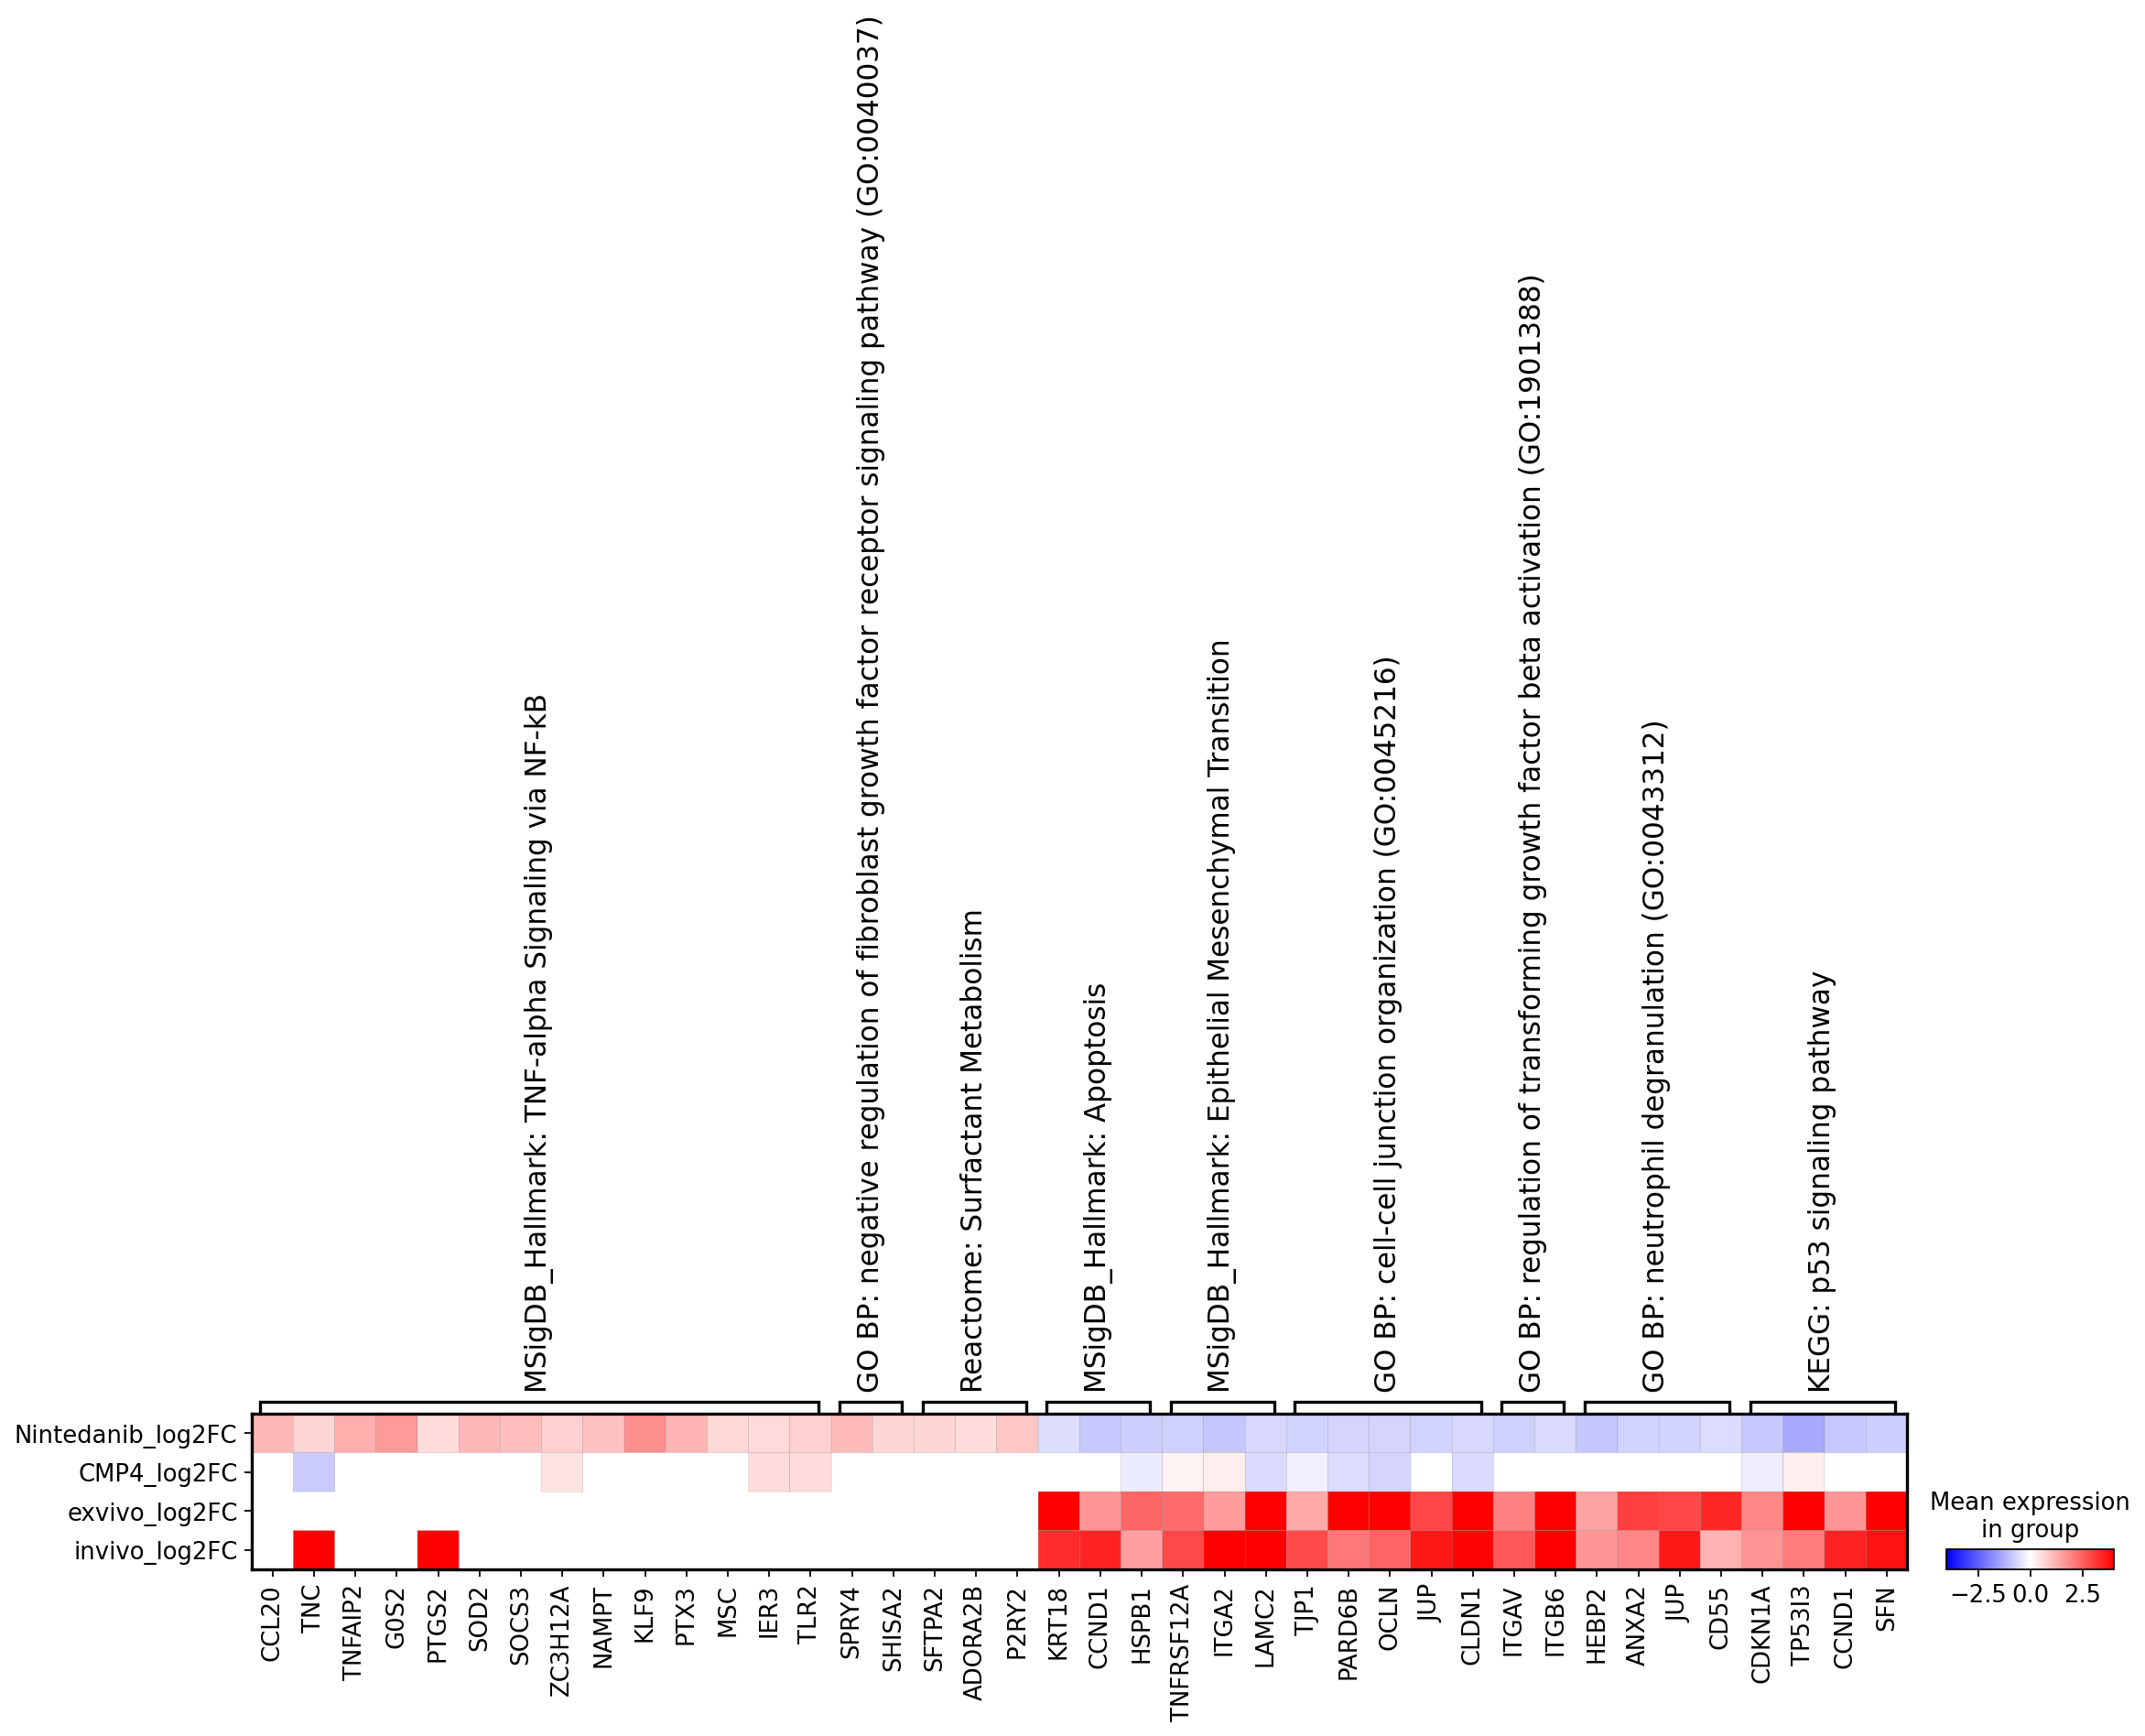

In [40]:
sc.pl.matrixplot(viz, gs_dict1, groupby = 'treatment_effect', dendrogram=False,
                 vmin=-4, vmax=4, cmap=my_map, save='hPCLS_aberrant_basaloid_Nintedanib_effects_DGE.pdf' )

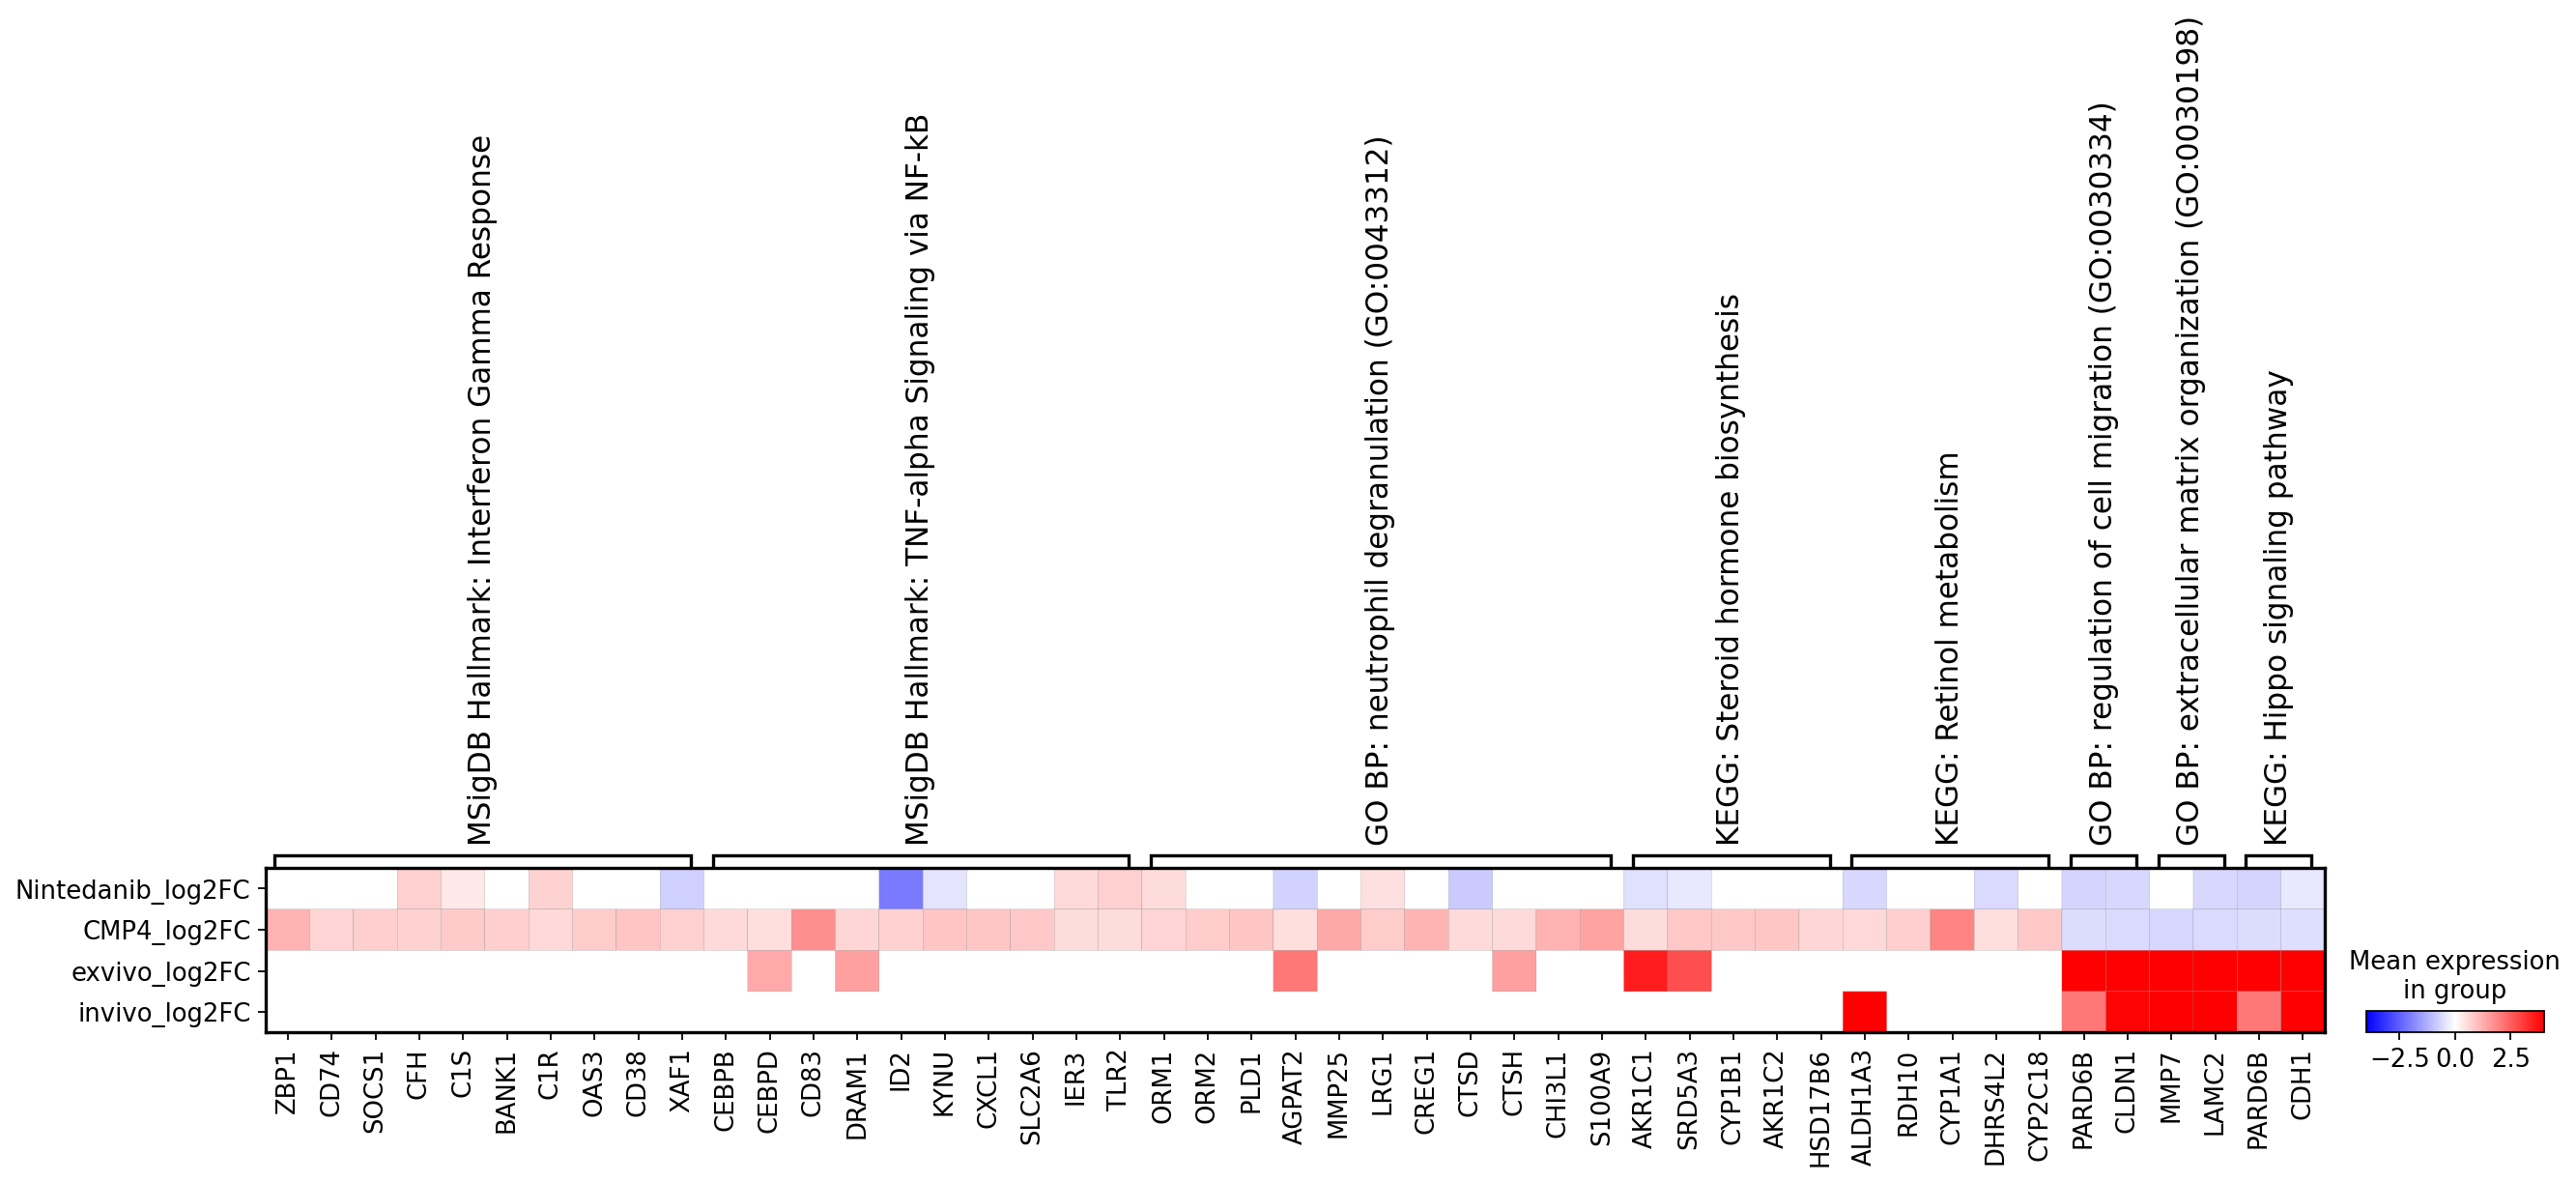

In [30]:
sc.pl.matrixplot(viz, gs_dict2, groupby = 'treatment_effect', dendrogram=False,
                 vmin=-4, vmax=4, cmap='bwr', save='hPCLS_aberrant_basaloid_cmp4_effects_DGE.pdf' )